In [1]:
%matplotlib notebook

import h5py
import matplotlib.pyplot as plt
from numpy import *
import pandas as pd
import os
import sys
import scipy.optimize as opt
from typing import Dict, Any
import recordclass.recordclass as rc
from itertools import product

if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"
sys.path.append(repo_path)
# local imports
import HamamatsuH5
from Iterations import Iterations,seed_permute
from PlottingH5 import default_plotting, iterate_plot_2D

In [2]:
h5file = h5py.File('results.hdf5',mode='r+')

iterations = Iterations(h5file)
#Find number of measurements per experiment
measurements = h5file['settings/experiment/measurementsPerIteration'][()]+1
num_its = len(h5file['iterations'])

iterations
#Find independent variable names and values
#indep_vars = DataH5.get_indep_vars(h5file)
#iVars = list(indep_vars.keys())

# map iterations to independent variable values
# iterations = DataH5.make_iterations_df(h5file, iVars)

    iteration  MOT_loading_time  PGC_1_time
0           0              60.0         0.0
1           1              69.0         0.0
2           2              78.0         0.0
3           3              87.0         0.0
4           4              96.0         0.0
..        ...               ...         ...
116       116             114.0        10.0
117       117             123.0        10.0
118       118             132.0        10.0
119       119             141.0        10.0
120       120             150.0        10.0

[121 rows x 3 columns]

## Create n-darray of iteration numbers
* useful when there are multiple independent variables
* Indexing is [ivar1,ivar2,ivar3,...,ivarn]
* ivar ordering is alphabetical
* identical to ordering of keys in indep_vars

# Hamamatsu

In [3]:
# Set ROI
fg = HamamatsuH5.set_frame_grabber_region(h5file)
width = fg['right']-fg['left']
height = fg['bottom']-fg['top']

# For documentation try > help(HMROI)
roi = HamamatsuH5.HMROI(width,height,dic = {
    "left" : 2,
    "right" : 5,
    "top" : 4,
    "bottom" : 7
})

#Load data into memory
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
# pixel-by-pixel data indexed : [iteration, measurement, shot, y-pixel, x-pixel]
hm_pix = HamamatsuH5.load_data(h5file,roi)

#take pixel-by-pixel data and treat it into counter data then mean data
# "count" data indexed : [iteration, measurement, shot]
hm_counts = hm_pix.sum(3).sum(3)
# mean count data indexed : [iteration, shot]
mus = hm_counts.mean(1)
# standard deviation in mean indexed : [iteration, shot]
ers = hm_counts.std(1)/sqrt(measurements)

## Plot Histograms of count data

In [4]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt.subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(hm_counts[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=30)
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")

You're about to plot 121 histograms. Are you sure you want to do that? (y/N) : 2
You have chosen not to plot the histograms.


## Plot mean count data
* If only 1 iteration : Prints out means for each shot and the corresponding standard deviation
* If there is 1 independent variable : Plot means for each iteration with error bars
* If there are 2 independent variables : show image of means for each iteration.

<IPython.core.display.Javascript object>


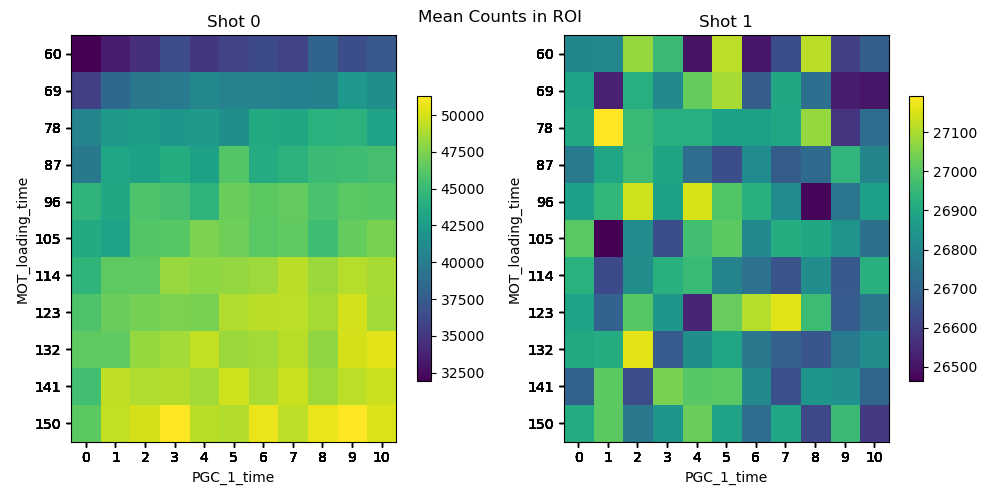

In [4]:
default_plotting(iterations,mus,ers,shots_per_measurement,description="Mean Counts in ROI")

## 2D as many 1D

* Often, when a 2D scan is performed it's more enlightening to plot each row (or column) of data as a line graph
* This Block of cells acomplishes that task


Which Independent variable is on the x-axis? :
	0) : MOT_loading_time
	1) : PGC_1_time
0


<IPython.core.display.Javascript object>


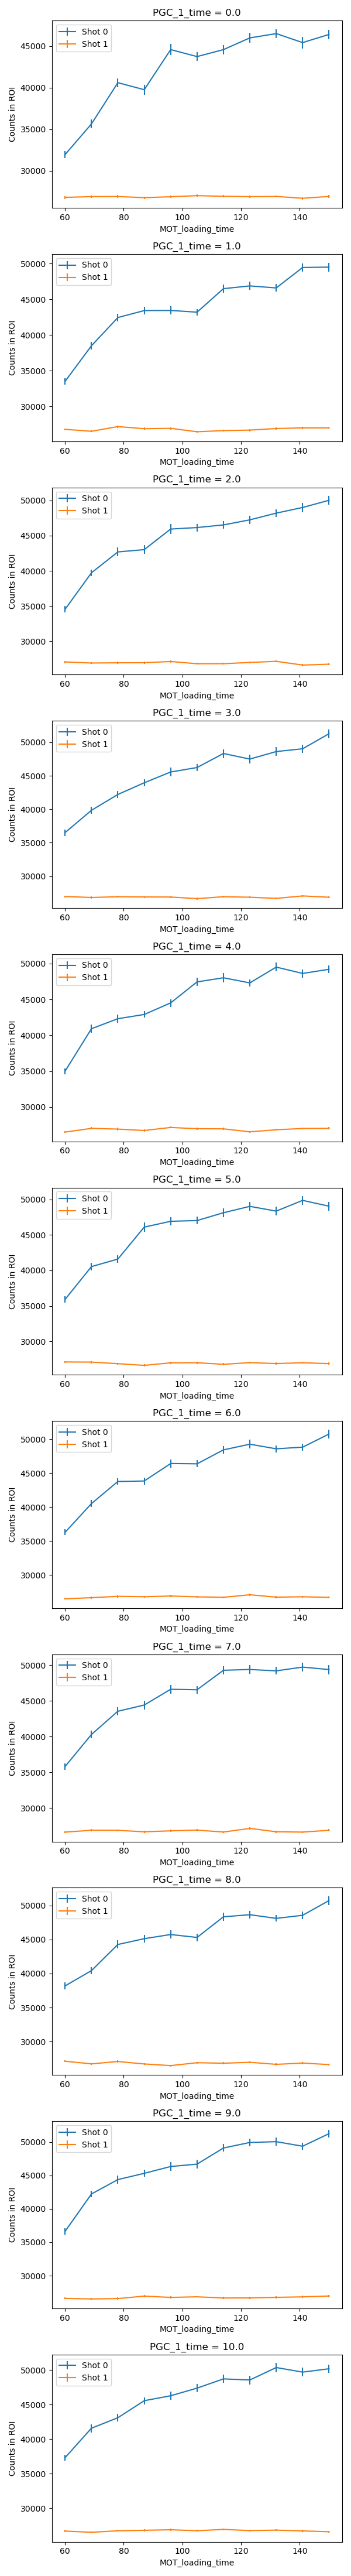

11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)
11 (11,) (11,)


In [7]:
# Check that there are 2 independent variables
rgs = {
    "iterations": iterations,
    "data": mus,
    "data_error": ers,
    "description": "Counts in ROI",
}

iterate_plot_2D(**rgs)

In [38]:
print(mus_nd.shape)

(11, 11)


In [23]:
print(x_ivar_ind, x_ivar)

0 MOT_loading_time


<IPython.core.display.Javascript object>


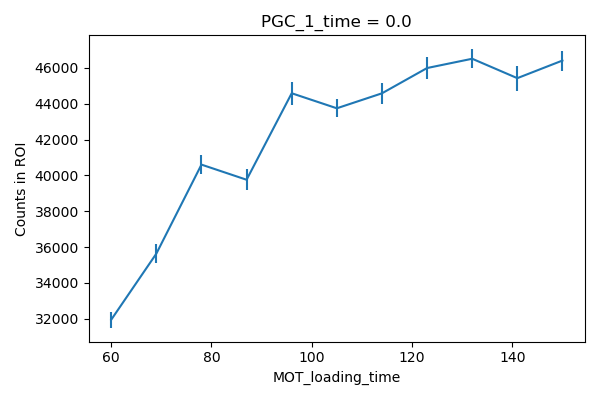

<IPython.core.display.Javascript object>


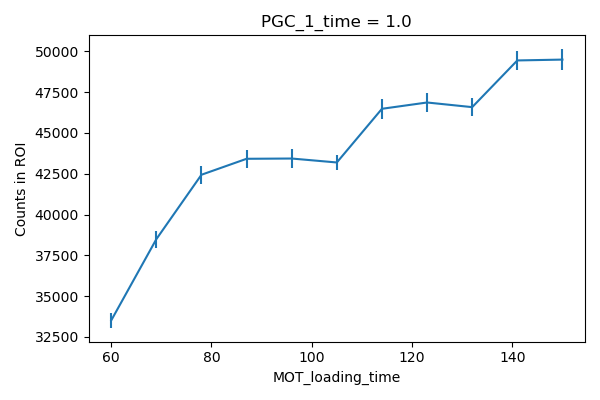

<IPython.core.display.Javascript object>


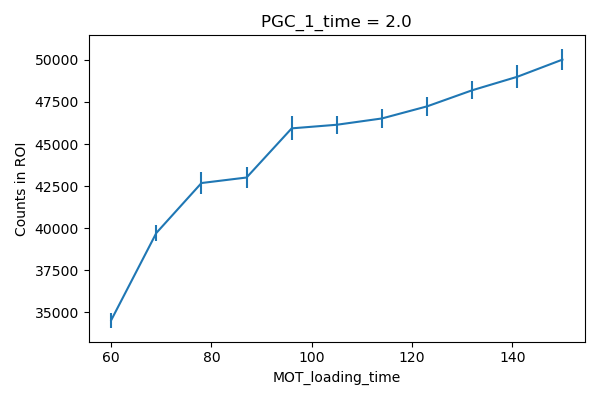

<IPython.core.display.Javascript object>


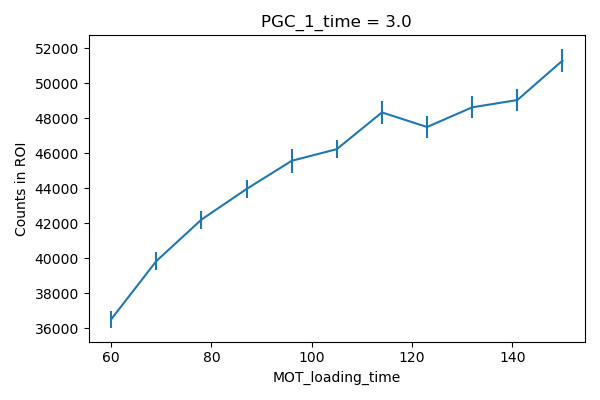

<IPython.core.display.Javascript object>


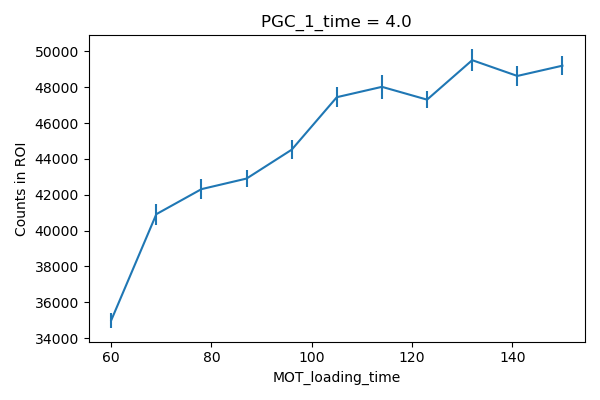

<IPython.core.display.Javascript object>


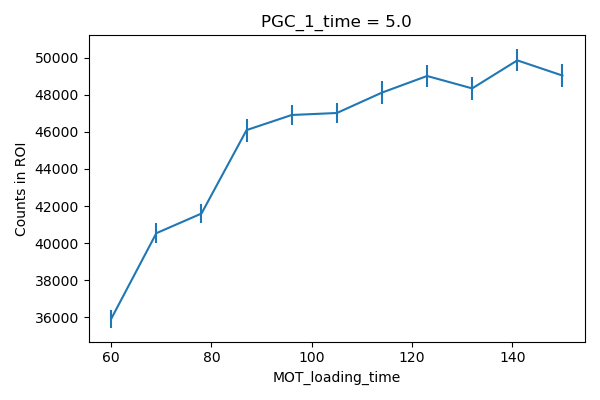

<IPython.core.display.Javascript object>


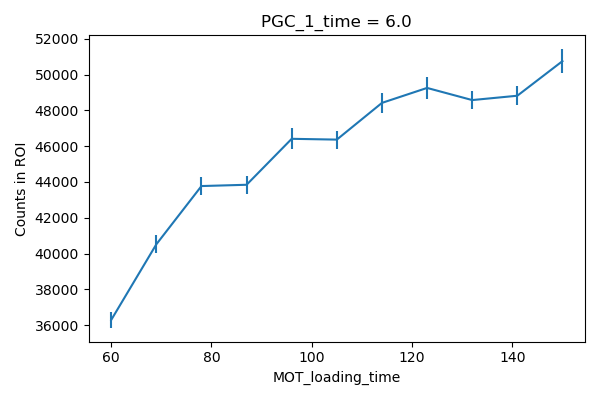

<IPython.core.display.Javascript object>


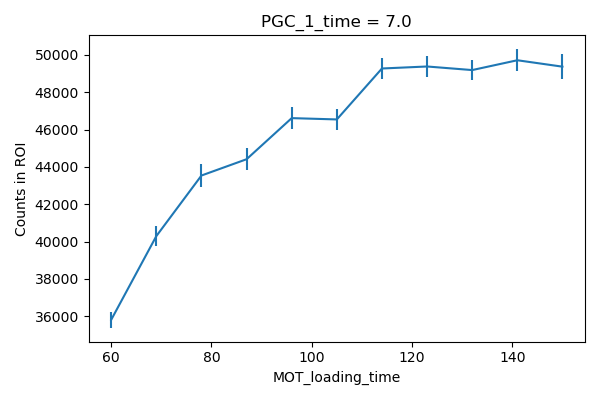

<IPython.core.display.Javascript object>


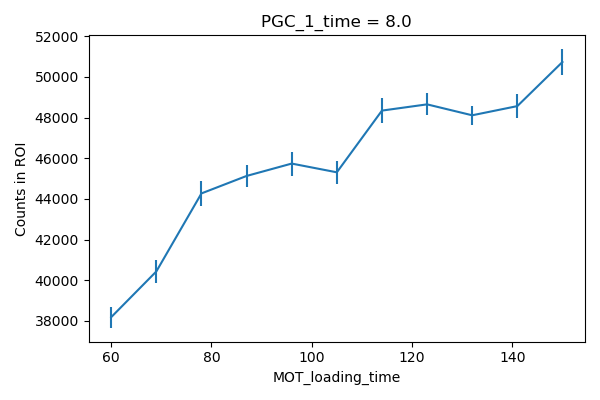

<IPython.core.display.Javascript object>


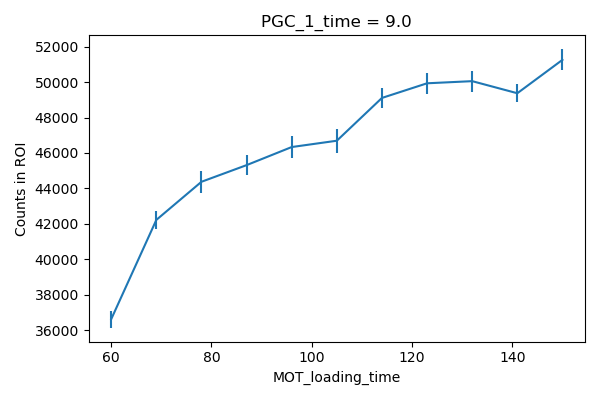

<IPython.core.display.Javascript object>


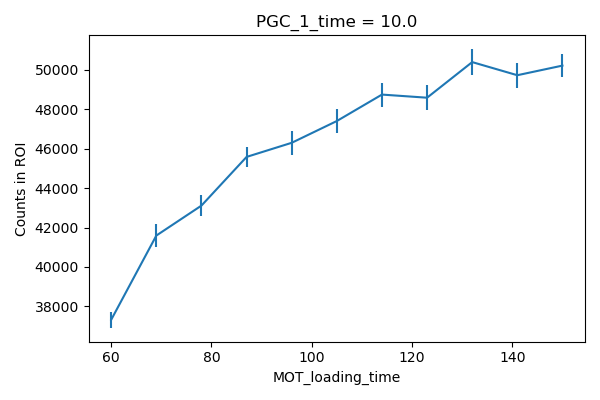

In [13]:
data = mus[:,0]
data_error = ers[:,0]
description = "Counts in ROI"

data_nd = iterations.fold_to_nd(data)
error_nd = iterations.fold_to_nd(data_error)
if not x_ivar_ind : # TODO: check that this is the right variable (x or y?)
    data_nd = data_nd.T
    error_nd = error_nd.T

x_vals = sorted(iterations.independent_variables[x_ivar])
for i, data_vals in enumerate(data_nd):
    y_val = sorted(iterations.independent_variables[y_ivar])[i]
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.errorbar(x_vals,data_vals,yerr=error_nd[i])
    ax.set_xlabel(x_ivar)
    ax.set_ylabel(description)
    ax.set_title(f"{y_ivar} = {y_val}")
    fig.tight_layout()
    fig.show

In [ ]:
for i

In [ ]:
sl = ["0"]*len(it_nd.shape)
sl[x_ivar_ind] = ":"
nd_sl = eval(f"s_[{','.join(sl)}]")

In [ ]:
print(nd_sl)
new_sl = list(nd_sl)
while True:
    fails = 0
    for i,var in enumerate(iterations.ivars):
        if i != x_ivar_ind and new_sl[i] < len(iterations.independent_variables[x_ivar]):
            new_sl[i] += 1
        else:
            fails += 1
    
    if fails == len(iterations.ivars):
        break
nd_sl = tuple(new_sl)
print(nd_sl)

In [ ]:
it_nd = iterations.fold_to_nd()
it_nd[nd_sl]

In [ ]:
it_nd[1,:]

## Show images taken within ROI

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt.subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for iteration, row in iterations.iterrows():
    i = row['iteration']
    ivs = {iVar: row[iVar] for iVar in iVars}
    axarr[i].imshow(hm_pix[i,:,im_shot,:,:].mean(0))
    axarr[i].set_title(str(row))
fig.tight_layout()
fig.show()

## Plot Histgram data of each picture for each iteration
* Very memory hungry!
* Please clear output before saving, copying or pushing if this cell was run

In [ ]:
im_width = roi.right-roi.left
im_height = roi.bottom-roi.top
for iteration, row in iterations.iterrows():
    i = row['iteration']
    fig,axarr = plt.subplots(im_height,im_width,figsize = (10,10))
    for y in range(im_height):
        for x in range(im_width):
            bns = 20
            for shot in range(shots_per_measurement):
                axarr[y,x].hist(hm_pix[i,:,shot,y,x],bins=bns,histtype='step',label = f"Shot {shot}")
            axarr[y,x].set_title(f"x = {x}, y = {y}")
            axarr[y,x].legend()
    fig.suptitle(str(row))
    fig.tight_layout()
    fig.show()

# Loading

In [ ]:
def shot_error(probability: float,samples: int):
    """
    Args:
        probability : number between 0 and 1. Measured probability of an event occurring 
        samples : number of samples used to measure the ratio
    Returns:
        shot noise uncertainty. Uncertainty in probability due to statistical variations
    """
    return sqrt(probability*(1-probability)/samples)

shots = 2

# Set count data variable, so this works regadless of device
count_data = hm_counts
cut = 24000  # 0 atom - 1 atom cut
multi_cut = 40000  # 1 atom - multi atom cut

zero_loading = (count_data < cut).sum(1)/measurements
zero_loading_error_bar = shot_error(zero_loading, measurements)
multi_loading = (count_data > multi_cut).sum(1)/measurements
multi_loading_error_bar = shot_error(multi_loading, measurements)
single_loading = 1-(zero_loading+multi_loading)
single_loading_error_bar = shot_error(single_loading, measurements)
multi_to_single_loading = multi_loading/single_loading
multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)

loadings = {
    0: "Zero",
    1: "Single",
    2: "Multi",
    3: "Multi_to_Single"
}

for num,name in loadings.items():
    rate = eval(f"{name.lower()}_loading")
    rate_error_bar = eval(f"{name.lower()}_loading_error_bar")
    PlottingH5.default_plotting(iterations,rate,rate_error_bar,shots=shots,description = f"{name} atom loading")

# Retention

In [ ]:
def shot_error(probability: float,samples: int):
    """
    Args:
        probability : number between 0 and 1. Measured probability of an event occurring 
        samples : number of samples used to measure the ratio
    Returns:
        shot noise uncertainty. Uncertainty in probability due to statistical variations
    """
    return sqrt(probability*(1-probability)/samples)

shots = 2

# Set count data variable, so this works regadless of device
count_data = hm_counts
cut = 24000  # 0 atom - 1 atom cut
multi_cut = 40000  # 1 atom - multi atom cut

single_loading = (count_data < multi_cut)*(count_data > cut)  # Measurements that were loaded
retained = single_loading[...,1:2]*single_loading[...,0:1]  # Measurements that were retained
loaded = single_loading[...,0:1].sum(1)  # Number of loaded measurements in each iteration

retention = retained.sum(1)/loaded
retention_error_bar = shot_error(retention,loaded)

PlottingH5.default_plotting(iterations,retention,retention_error_bar,description = "Retention")